# **1. Data Process Categorical**
---

## **1.1 Imports**

In [1]:
import pandas as pd
import glob
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import json
from sklearn.pipeline import Pipeline
from joblib import dump
import os

c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **1.2 File imports**

In [2]:
# folder for txt files
folder = 'qws1_dataset/*.txt'

# list of files
files = glob.glob(folder)

# number of files
count = 1
for file in files:
    print(f'File number {count} - {file}')
    count += 1

File number 1 - qws1_dataset\qws1.txt


In [3]:
df_list = []

for file in files:
    try:
        # Detect header dynamically
        with open(file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        header_line = None
        for i, line in enumerate(lines):
            if ',' in line:
                header_line = i
                break
        
        if header_line is None:
            print(f"Skipping {file}: No CSV content found")
            continue
        
        # Read from detected header line
        df = pd.read_csv(file, sep=',', skiprows=header_line)
        df_list.append(df)
    
    except Exception as e:
        print(f"Skipping {file}: {e}")

if df_list:
    df = pd.concat(df_list, ignore_index=True, sort=False)
else:
    print("No valid files")

## **1.3 Features check**

### **1.3.1 Heatmap**

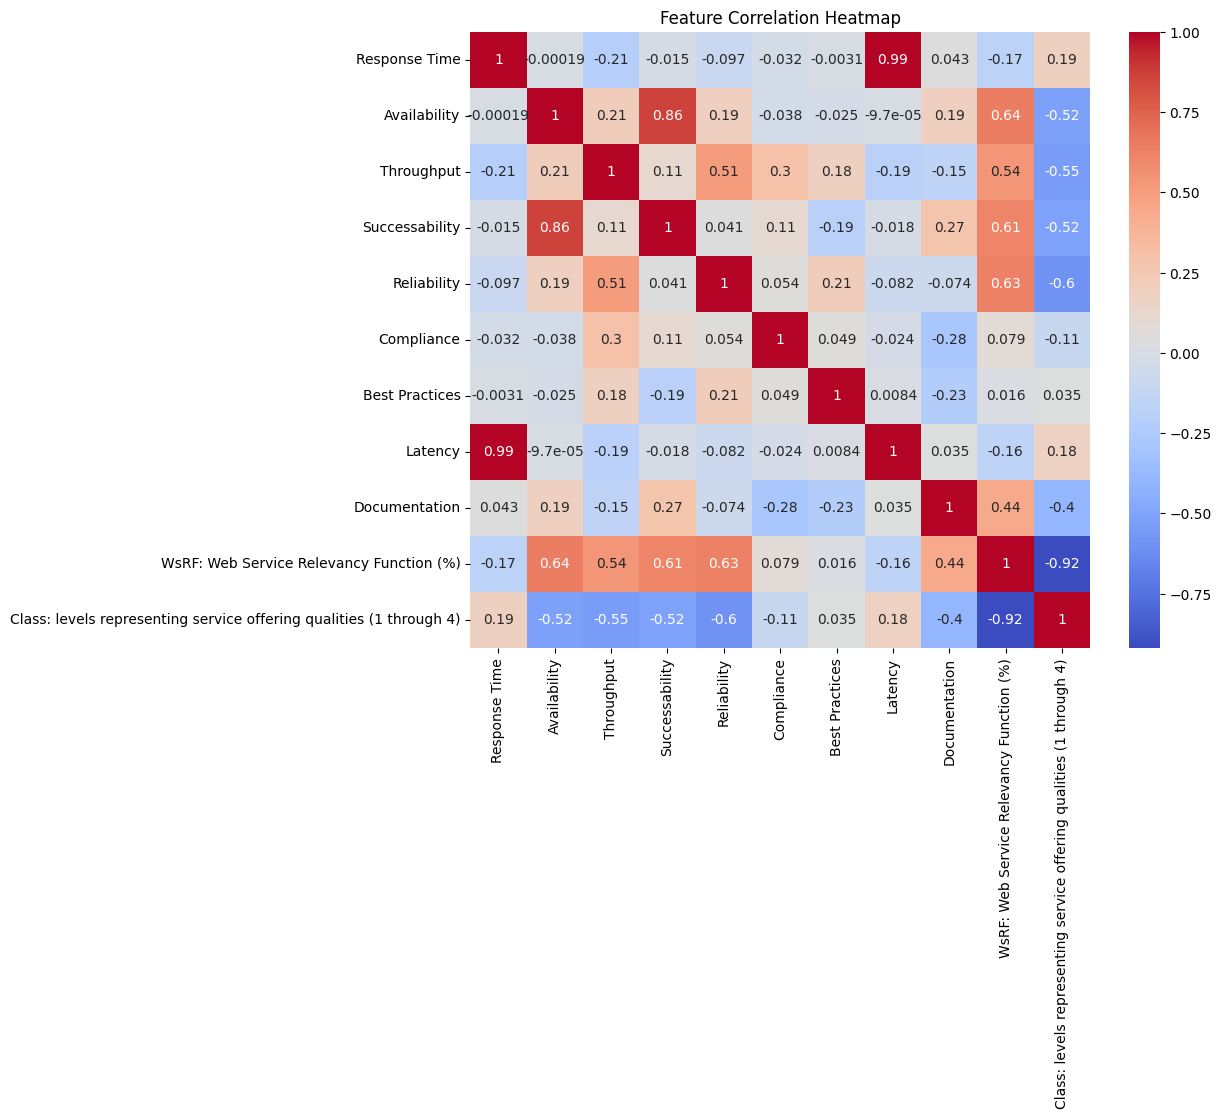

In [4]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

Dropping columns that dont add value to the model:
 - Service Name, WSDL Address, Class: levels representing service offering qualities (1 through 4) (target value), WsRF: Web Service Relevancy Function (%) (has negative correlation with target value)

### **1.3.2 Data Leakage Check**

In [5]:
# Correlation
corr_matrix = df.select_dtypes(include=['number']).corr()
print("Correlation of features with target:")
corr_matrix['Class: levels representing service offering qualities (1 through 4)'].sort_values(ascending=False)

Correlation of features with target:


Class: levels representing service offering qualities (1 through 4)    1.000000
Response Time                                                          0.187447
Latency                                                                0.176276
Best Practices                                                         0.034588
Compliance                                                            -0.106655
Documentation                                                         -0.400257
Successability                                                        -0.516015
Availability                                                          -0.524069
Throughput                                                            -0.548563
Reliability                                                           -0.602594
WsRF: Web Service Relevancy Function (%)                              -0.918824
Name: Class: levels representing service offering qualities (1 through 4), dtype: float64

- Dropped of columns that would put more noise in the model
- Defined target column
- Scaled numeric columns and encoded categorical values

In [6]:
# 1. Drop non-feature and correlated columns
drop_cols = ['Service Name', 'WSDL Address', 'Class: levels representing service offering qualities (1 through 4)',
            'WsRF: Web Service Relevancy Function (%)']
feature_cols = [col for col in df.columns if col not in drop_cols]

X = df[feature_cols].copy()
y = df['Class: levels representing service offering qualities (1 through 4)'].copy()

# 2. Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Classes:", label_encoder.classes_)

Classes: [1 2 3 4]


## **1.4 Data Split**

- The data will be split 2 time and into 2 parts each time, using a ratio of 70% and 30%:
    - First split (70% training, 30% remaining).
    - Second split using only the 30% remaining data (70% test, 30% validation exported and used in a future section of the project). 
- According to the previous EDA analysis and correlation matrix, 4 columns will be dropped because it contain information irrelevant or leak into the target variable

In [7]:
# 3. First split: Train (70%) and Remaining (30%)
X_train, X_remaining, y_train, y_remaining = train_test_split(
    X, y_encoded,
    test_size=0.3,
    stratify=y_encoded,
    random_state=42
)

# 4. Split remaining: Test (70%) and Validation (30%)
X_test, X_val, y_test, y_val = train_test_split(
    X_remaining, y_remaining,
    test_size=0.3,
    stratify=y_remaining,
    random_state=42
)

# 5. Save training data
train_data = pd.concat([X_train.reset_index(drop=True),
                        pd.Series(y_train, name='Class').reset_index(drop=True)],
                       axis=1)

train_data.to_csv('qws1_dataset/training_data_classification.csv', index=False)

# 6. Save test data
test_data = pd.concat([X_test.reset_index(drop=True),
                       pd.Series(y_test, name='Class').reset_index(drop=True)],
                      axis=1)

test_data.to_csv('qws1_dataset/test_data_classification.csv', index=False)

# 7. Save validation data
val_data = pd.concat([X_val.reset_index(drop=True),
                      pd.Series(y_val, name='Class').reset_index(drop=True)],
                     axis=1)

val_data.to_csv('qws1_dataset/validation_data_classification.csv', index=False)

# 8. Shapes and class distribution
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, Validation shape: {X_val.shape}")
print("Class distribution in Train:", {i: sum(y_train == i) for i in set(y_train)})
print("Class distribution in Test:", {i: sum(y_test == i) for i in set(y_test)})
print("Class distribution in Validation:", {i: sum(y_val == i) for i in set(y_val)})

Train shape: (254, 9), Test shape: (77, 9), Validation shape: (33, 9)
Class distribution in Train: {np.int64(0): np.int64(28), np.int64(1): np.int64(70), np.int64(2): np.int64(84), np.int64(3): np.int64(72)}
Class distribution in Test: {np.int64(0): np.int64(9), np.int64(1): np.int64(21), np.int64(2): np.int64(25), np.int64(3): np.int64(22)}
Class distribution in Validation: {np.int64(0): np.int64(4), np.int64(1): np.int64(9), np.int64(2): np.int64(11), np.int64(3): np.int64(9)}


---
# **2. Pipeline**
---

## **2.1 Baseline**

- This is the baseline evaluation, setting a reference point for future models. Any model trained should aim for an Accuracy, F1 and ROC-AUC higher to be better than the baseline.

In [10]:
# Dummy classifier
baseline_clf = DummyClassifier(strategy='most_frequent')
baseline_clf.fit(X_train, y_train)
baseline_pred = baseline_clf.predict(X_test)

# Accuracy
baseline_acc = accuracy_score(y_test, baseline_pred)

# F1 Score 
baseline_f1 = f1_score(y_test, baseline_pred, average='macro')

# ROC-AUC
baseline_prob = baseline_clf.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
baseline_roc_auc = roc_auc_score(y_test_bin, baseline_prob, average='macro', multi_class='ovr')
baseline_precision = precision_score(y_test, baseline_pred, average='macro')
baseline_recall = recall_score(y_test, baseline_pred, average='macro')

print(f"Baseline (Majority Class) Accuracy: {baseline_acc:.4f}")
print(f"Baseline F1 Score (Macro): {baseline_f1:.4f}")
print(f"Baseline ROC-AUC (Macro): {baseline_roc_auc:.4f}")
print(f"Baseline Precision (Macro): {baseline_precision:.4f}")
print(f"Baseline Recall (Macro): {baseline_recall:.4f}")

Baseline (Majority Class) Accuracy: 0.3247
Baseline F1 Score (Macro): 0.1225
Baseline ROC-AUC (Macro): 0.5000
Baseline Precision (Macro): 0.0812
Baseline Recall (Macro): 0.2500


c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## **2.2 Model Definition**

### **2.2.1 Model Prediction**

In [11]:
# Models
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))
    ])
}

results = {}

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
# Baseline metrics
results['Baseline'] = {
    'Accuracy': baseline_acc,
    'Precision': baseline_precision,
    'Recall': baseline_recall,
    'F1': baseline_f1,
    'ROC-AUC': baseline_roc_auc
}

predictions_df = pd.DataFrame({'Actual Values': y_test})

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Predictions for each model
    predictions_df[name] = y_pred

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')

    results[name] = {
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc
    }

# Baseline predictions
predictions_df['Baseline'] = baseline_pred

print("\nPredictions vs Actual:")
predictions_df


Predictions vs Actual:


,Actual Values,Logistic Regression,Random Forest,XGBoost,Baseline
0,3,2,2,2,2
1,1,1,0,0,2
2,3,3,3,3,2
3,2,2,2,2,2
4,3,3,3,3,2
...,...,...,...,...,...
72,0,0,0,0,2
73,2,2,2,2,2
74,3,2,2,2,2
75,2,2,2,2,2


### **2.2.2 Evaluation**

It will be used 5 metrics:
- Accuracy: proportion of predictions that the model got right
- Recall: proportion of positive cases that the model identified correctly
- Precision: proportion of predicted positive cases where the true label is actually positive
- F1: overall metric that combines recall and precision
- Receiver Operating Characteristic – Area Under the Curve (ROC-AUC): shows how well a model can separate positive and negative classes

In [12]:
# DataFrame with metrics
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']

results_df

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Baseline,0.324675,0.081169,0.250000,0.122549,0.500000
1,Logistic Regression,0.740260,0.768654,0.745916,0.748448,0.943089
2,Random Forest,0.753247,0.769680,0.754553,0.749941,0.925406
3,XGBoost,0.714286,0.739583,0.720202,0.719570,0.915122


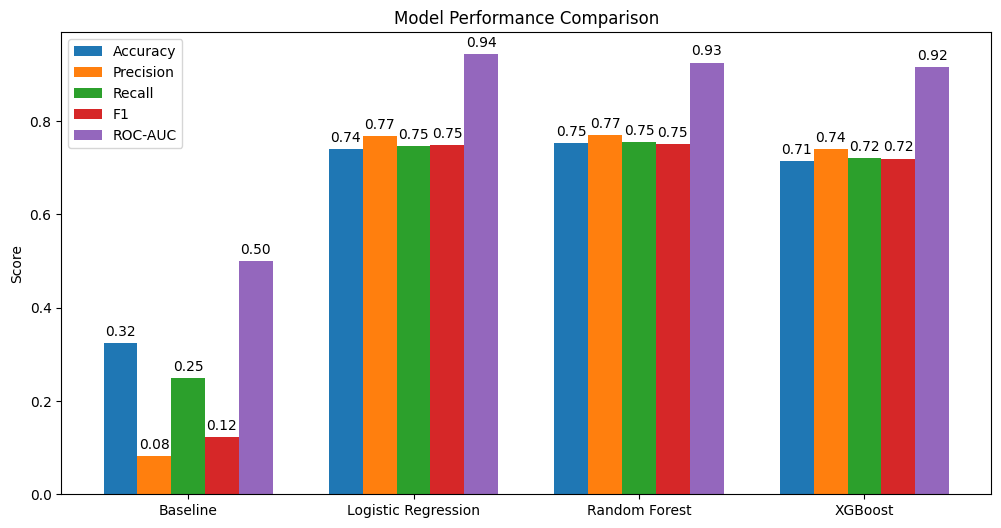

In [13]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
models_names = results_df['Model']
values = [results_df[m] for m in metrics]

x = np.arange(len(results_df)) 
width = 0.15 

fig, ax = plt.subplots(figsize=(12, 6))
for i, metric in enumerate(metrics):
    bars = ax.bar(x + i*width, values[i], width, label=metric)
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_xticks(x + width*2)
ax.set_xticklabels(models_names)
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend()
plt.show()

---
# **3. Hyperparameter tuning**
---

## **3.1 Random Forest**

In [14]:
# Parameter grid
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring={'f1_macro':'f1_macro','accuracy':'accuracy','roc_auc_ovr':'roc_auc_ovr'},
    refit='accuracy',
    cv=cv_strategy,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True,
    error_score='raise'
)

random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best Score (CV Accuracy):", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Best Score (CV Accuracy): 0.7992156862745098


## **3.2 Logistic Regression**

In [15]:
# Parameter grid
param_grid_lr = {
    'classifier__penalty': ['l2'],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['lbfgs', 'saga']
}

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
lr_search = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_grid_lr,
    n_iter=20, 
    scoring={'f1_macro':'f1_macro','accuracy':'accuracy','roc_auc_ovr':'roc_auc_ovr'},
    refit='accuracy',
    cv=cv_strategy,
    random_state=42,
    n_jobs=-1,
    return_train_score=True,
    error_score='raise'
)

lr_search.fit(X_train, y_train)

print("Best Params (LogisticRegression):", lr_search.best_params_)
print("Best Score (CV Accuracy):", lr_search.best_score_)

c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params (LogisticRegression): {'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}
Best Score (CV Accuracy): 0.8424313725490196


## **3.3 XGBoost**

In [16]:
# Parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

xgb = XGBClassifier(
                    eval_metric='mlogloss', 
                    random_state=42,
                    num_class=len(np.unique(y_train)),
                    scale_pos_weight=1)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_xgb,
    n_iter=10, 
    scoring={'f1_macro':'f1_macro','accuracy':'accuracy','roc_auc_ovr':'roc_auc_ovr'},
    refit='accuracy',
    cv=cv_strategy,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True,
    error_score='raise'
)

xgb_search.fit(X_train, y_train)

print("Best Params (XGBoost):", xgb_search.best_params_)
print("Best Score (CV Accuracy):", xgb_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:26:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params (XGBoost): {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best Score (CV Accuracy): 0.7992156862745098


## **3.4 Cross-Validation for Best Model**

In [17]:
all_models = {
    'Baseline': baseline_clf,
    'Logistic Regression Untuned': models['Logistic Regression'],
    'Random Forest Untuned': models['Random Forest'],
    'XGBoost Untuned': models['XGBoost'],
    'Logistic Regression Tuned': lr_search.best_estimator_,
    'Random Forest Tuned': random_search.best_estimator_,
    'XGBoost Tuned': xgb_search.best_estimator_
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}
for name, model in all_models.items():
    scores = cross_validate(
        model,
        X,
        y_encoded,
        cv=cv_strategy,
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
    )
    cv_results[name] = {
        'Accuracy': scores['test_accuracy'].mean(),
        'Precision': scores['test_precision_macro'].mean(),
        'Recall': scores['test_recall_macro'].mean(),
        'F1': scores['test_f1_macro'].mean(),
        'ROC-AUC': scores['test_roc_auc_ovr'].mean(),
        'Accuracy_std': scores['test_accuracy'].std(),
        'F1_std': scores['test_f1_macro'].std()
    }

cv_df = pd.DataFrame(cv_results).T.reset_index()
cv_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'Accuracy_std', 'F1_std']
cv_df = cv_df.sort_values(by='F1', ascending=False)

print("\nCross-Validation Ranking (mean ± std):")
for _, row in cv_df.iterrows():
    print(f"{row['Model']}: F1={row['F1']:.4f} ± {row['F1_std']:.4f}, Accuracy={row['Accuracy']:.4f} ± {row['Accuracy_std']:.4f}")

best_model_name = cv_df.iloc[0]['Model']
best_model = all_models[best_model_name]
print(f"\nBest model after cross-validation: {best_model_name}")

c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame


Cross-Validation Ranking (mean ± std):
Logistic Regression Tuned: F1=0.8469 ± 0.0506, Accuracy=0.8405 ± 0.0543
Logistic Regression Untuned: F1=0.8201 ± 0.0501, Accuracy=0.8158 ± 0.0499
Random Forest Untuned: F1=0.7983 ± 0.0341, Accuracy=0.8021 ± 0.0341
Random Forest Tuned: F1=0.7908 ± 0.0322, Accuracy=0.7993 ± 0.0318
XGBoost Tuned: F1=0.7897 ± 0.0318, Accuracy=0.8021 ± 0.0233
XGBoost Untuned: F1=0.7597 ± 0.0422, Accuracy=0.7747 ± 0.0271
Baseline: F1=0.1240 ± 0.0005, Accuracy=0.3297 ± 0.0018

Best model after cross-validation: Logistic Regression Tuned


The best-performing model based on F1 score is Logistic Regression Tuned, showing strong and consistent performance across all metrics:

- Accuracy (0.8405 ± 0.0543) -> The model correctly predicts about 84% of cases on average. The ±0.05 indicates moderate variability across folds, which is acceptable for this dataset size.
- Precision_macro (~0.8438) -> When the model predicts a class, it is correct about 84% of the time across all classes, indicating reliable predictions.
- Recall_macro (~0.8549) -> The model captures about 85% of actual cases, showing strong sensitivity and ability to identify true positives.
- F1_macro (0.8469 ± 0.0506) -> A balanced measure of precision and recall. At ~85%, the model demonstrates excellent overall performance.
- ROC_AUC_OVR (~0.9669) -> Outstanding ability to separate classes (close to 1.0). This suggests the model is highly effective at distinguishing between different service quality levels.

### **3.4.1 Predicted vs Actual Values**

In [18]:
# Predictions DataFrame
predictions_df = pd.DataFrame({'Actual': y_test})

# Baseline predictions
predictions_df['Baseline'] = baseline_pred

# Untuned models predictions
for name, model in models.items():
    predictions_df[f'{name}_Untuned'] = model.predict(X_test)

# Tuned models predictions
tuned_models = {
    'LogisticRegression_Tuned': lr_search.best_estimator_,
    'RandomForest_Tuned': random_search.best_estimator_,
    'XGBoost_Tuned': xgb_search.best_estimator_
}

for name, model in tuned_models.items():
    predictions_df[name] = model.predict(X_test)

predictions_df.head()

,Actual,Baseline,Logistic Regression_Untuned,Random Forest_Untuned,XGBoost_Untuned,LogisticRegression_Tuned,RandomForest_Tuned,XGBoost_Tuned
0,3,2,2,2,2,2,2,2
1,1,2,1,0,0,1,0,0
2,3,2,3,3,3,3,3,3
3,2,2,2,2,2,2,2,2
4,3,2,3,3,3,3,3,3


In [19]:
cv_df = pd.DataFrame(cv_results).T.reset_index()
cv_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'Accuracy_std', 'F1_std']
cv_df = cv_df.sort_values(by='Accuracy', ascending=False)

# Remover colunas std
cv_df = cv_df.drop(columns=['Accuracy_std', 'F1_std'])
cv_df

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
4,Logistic Regression Tuned,0.840525,0.843787,0.854881,0.846906,0.966894
1,Logistic Regression Untuned,0.815830,0.846493,0.810238,0.820133,0.963255
6,XGBoost Tuned,0.802093,0.827705,0.782202,0.789663,0.947619
2,Random Forest Untuned,0.802055,0.830532,0.793452,0.798256,0.950897
5,Random Forest Tuned,0.799315,0.824517,0.784167,0.790758,0.950505
3,XGBoost Untuned,0.774696,0.807412,0.752004,0.759673,0.943620
0,Baseline,0.329680,0.082420,0.250000,0.123969,0.500000


c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *ar

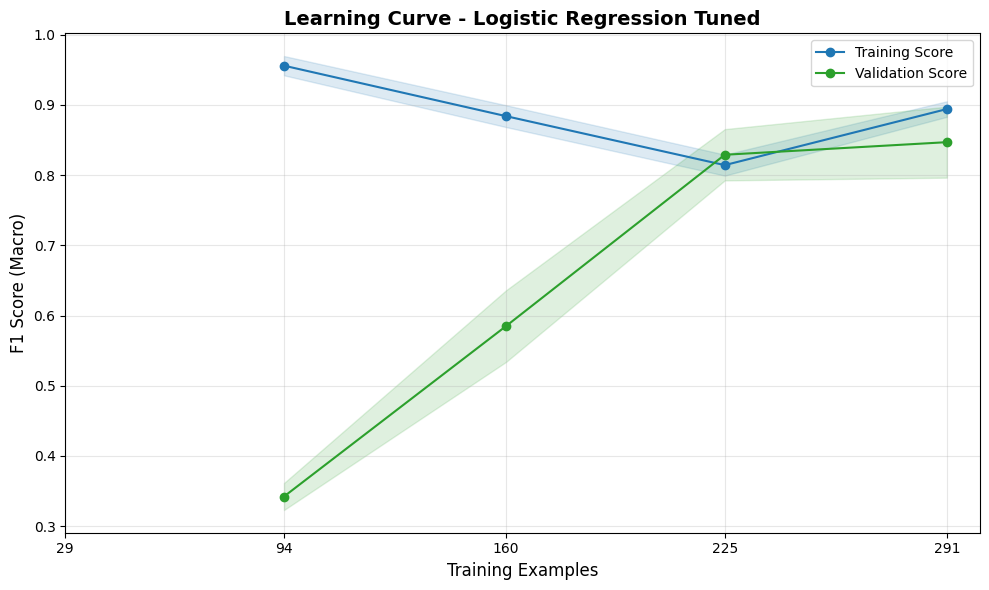

In [20]:
# Learning Curve for Best Model
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y_encoded, cv=cv_strategy, scoring='f1_macro', n_jobs=-1
)

# Medians and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='#1f77b4', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='#2ca02c', label='Validation Score')

# Confidence area
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='#1f77b4')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='#2ca02c')

# Ajustments
plt.title(f'Learning Curve - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Training Examples', fontsize=12)
plt.ylabel('F1 Score (Macro)', fontsize=12)
plt.xticks(train_sizes)
plt.grid(alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The learning curve illustrates how the F1 score (macro) evolves as the training set size increases:
1. Initial Phase (≈94 samples):
- Training Score: ≈ 0.95
- Validation Score: ≈ 0.34
- The model performs almost perfectly on the training set but very poorly on validation, indicating severe overfitting when trained on a small dataset.

2. Intermediate Phase (≈160 samples):
- Training Score: ≈ 0.89
- Validation Score: ≈ 0.58
- Validation performance improves significantly, while training score decreases slightly. The gap narrows, suggesting the model is learning more generalizable patterns.

3. Later Phase (≈225 samples):
- Training Score: ≈ 0.81
- Validation Score: ≈ 0.82
- Both curves converge closely, indicating good generalization and minimal overfitting at this stage.

4. Final Phase (≈291 samples):
- Training Score: ≈ 0.90
- Validation Score: ≈ 0.85
- Both curves stabilize near each other. The small remaining gap indicates mild overfitting, which is expected given the limited dataset size. The plateau in the validation curve suggests that adding more data may yield only marginal improvements unless combined with feature engineering or regularization adjustments.

5. Confidence Intervals:
- The shaded regions represent variability across folds.
- Wider intervals at smaller training sizes reflect instability due to limited data, while narrower intervals at larger sizes indicate more consistent performance.

## **3.5 Visualizations**

### **3.5.1 Confusion Matrixes**

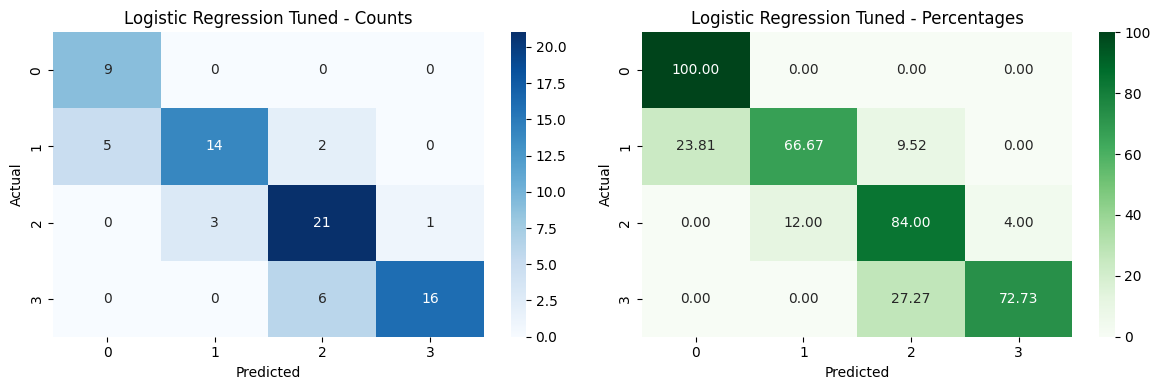

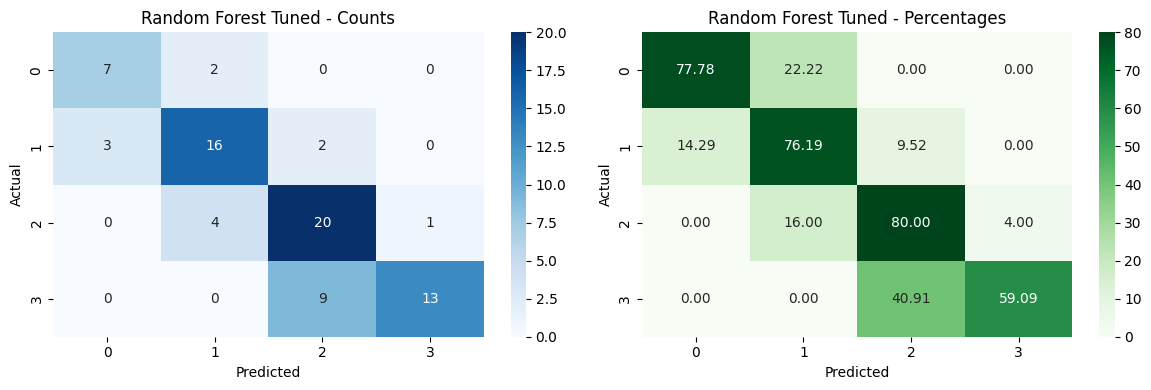

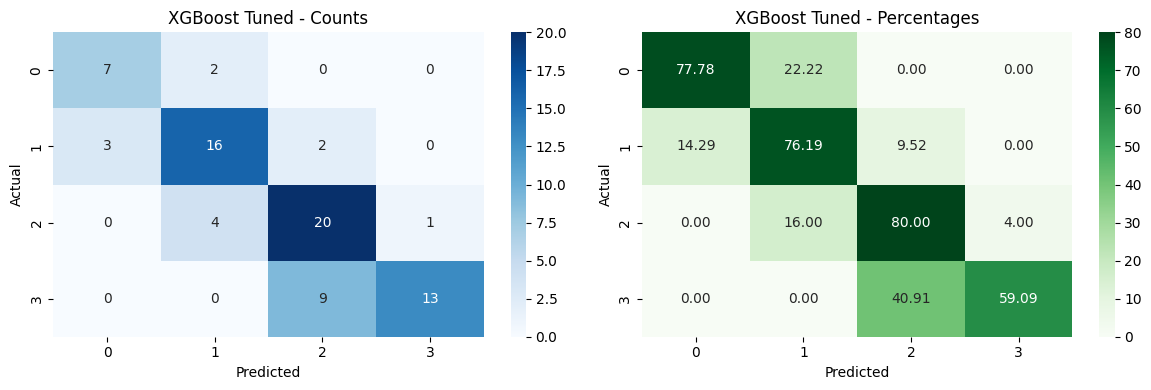

In [21]:
# Confusion matrices
conf_matrices = {}

# Tuned models
for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices[name] = cm

name_mapping = {
    'LogisticRegression_Tuned': 'Logistic Regression Tuned',
    'RandomForest_Tuned': 'Random Forest Tuned',
    'XGBoost_Tuned': 'XGBoost Tuned'
}

# Plot
for name, cm in conf_matrices.items():
    display_name = name_mapping.get(name, name)

    # Normalize for percentages
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'{display_name} - Counts')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Percentages
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', ax=axes[1])
    axes[1].set_title(f'{display_name} - Percentages')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

Each confusion matrix shows actual values vs predicted classes. The left matrix displays raw counts, while the right matrix shows percentages normalized per actual class. This helps identify which classes are predicted accurately and where misclassifications occur relative to class size.

### **3.5.2 ROC curve and AUC score**

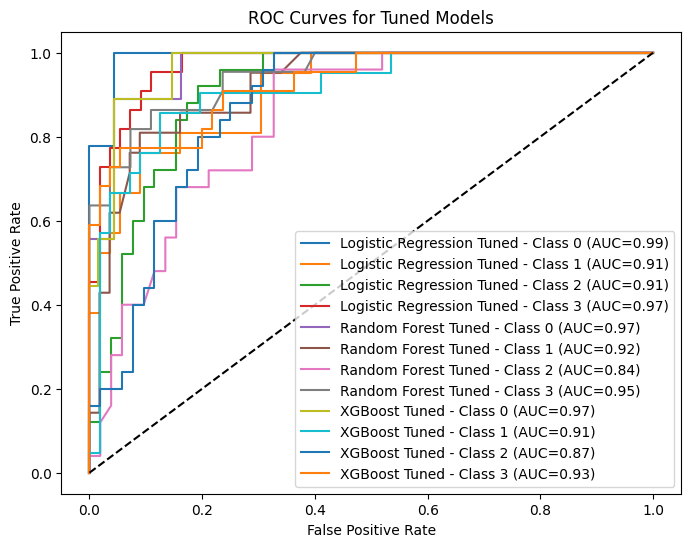

In [22]:
roc_data = {}
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

for name, model in tuned_models.items():
    y_prob = model.predict_proba(X_test)
    fpr = {}
    tpr = {}
    roc_auc_dict = {}

    # ROC for each class
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])

    roc_data[name] = (fpr, tpr, roc_auc_dict)

name_mapping = {
    'LogisticRegression_Tuned': 'Logistic Regression Tuned',
    'RandomForest_Tuned': 'Random Forest Tuned',
    'XGBoost_Tuned': 'XGBoost Tuned'
}

plt.figure(figsize=(8, 6))
for name, (fpr, tpr, roc_auc_dict) in roc_data.items():
    display_name = name_mapping.get(name, name)
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'{display_name} - Class {i} (AUC={roc_auc_dict[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Tuned Models')
plt.legend()
plt.show()

1) Class 0 – Excellent performance across all models:
    - Logistic Regression Tuned: AUC = 0.99
    - Random Forest Tuned: AUC = 0.97
    - XGBoost Tuned: AUC = 0.97

2) Classes 1 and 3 – Strong performance:
    - Class 1:
        - Logistic Regression: 0.91
        - Random Forest: 0.92
        - XGBoost: 0.91
    - Class 3:
        - Logistic Regression: 0.97
        - Random Forest: 0.95
        - XGBoost: 0.93

3) Class 2 – Weaker performance compared to others:
    - Logistic Regression: 0.91
    - Random Forest: 0.84
    - XGBoost: 0.87

ROC curves show that all models achieve near-perfect discrimination for class 0 and strong performance for classes 1 and 3. However, class 2 is consistently harder to classify (AUC ~0.82–0.87), indicating potential overlap in feature space or insufficient data for this class.

---
# **4. Interpretability**
---

## **4.1 Feature Importance**

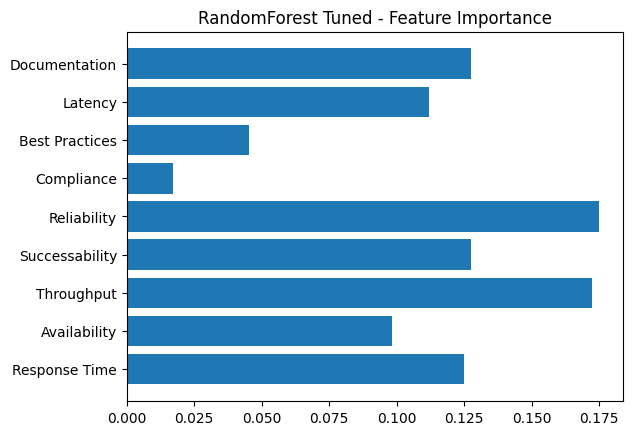

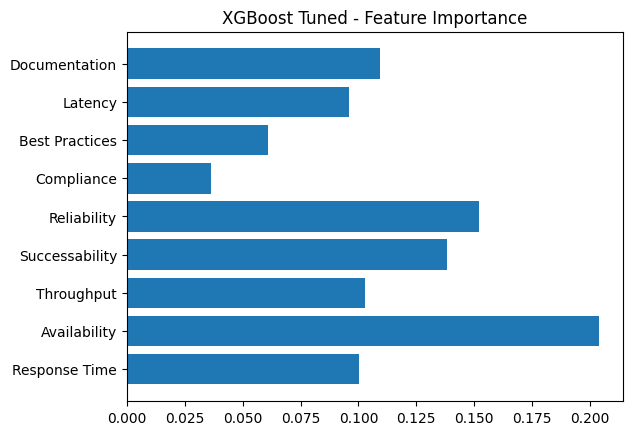

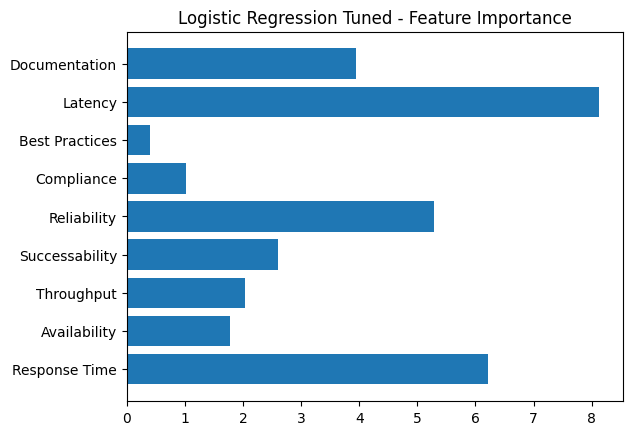

In [23]:
# RandomForest Tuned
rf_model = random_search.best_estimator_
importances_rf = rf_model.feature_importances_
plt.barh(feature_cols, importances_rf)
plt.title("RandomForest Tuned - Feature Importance")
plt.show()

# XGBoost Tuned
xgb_model = xgb_search.best_estimator_
importances_xgb = xgb_model.feature_importances_
plt.barh(feature_cols, importances_xgb)
plt.title("XGBoost Tuned - Feature Importance")
plt.show()

# Logistic Regression Tuned
lr_model = lr_search.best_estimator_
importances_lr = np.mean(np.abs(lr_model.named_steps['classifier'].coef_), axis=0)
plt.barh(feature_cols, importances_lr)
plt.title("Logistic Regression Tuned - Feature Importance")
plt.show()

1) Random Forest Tuned Importance:
    - Top Feature: Reliability is the most influential feature, indicating that service reliability strongly impacts the predicted quality level.
    - Other High-Impact Features: Throughput and Successability follow closely, suggesting performance and success rate are critical.
    - Moderate Importance: Documentation and Response Time still play a role but less than reliability.
    - Least Important: Compliance and Best Practices have minimal impact, meaning they contribute little to prediction accuracy.

2) XGBoost Tuned Importance:
    - Top Feature: Availability dominates, showing that uptime is the strongest predictor for XGBoost.
    - Balanced Importance: Reliability, Successability, and Throughput are all significant, reinforcing the importance of performance metrics.
    - Moderate Role: Documentation and Response Time are secondary factors.
    - Least Important: Compliance and Best Practices remain low, similar to Random Forest.

3) Logistic Regression Importance:
    - Top Feature: Latency has the highest coefficient magnitude, meaning delays strongly influence the predicted class.
    - Second Strongest: Response Time also matters significantly.
    - Moderate Impact: Reliability and Documentation contribute meaningfully.
    - Low Impact: Best Practices and Compliance have very small coefficients, confirming their limited predictive power.

Overall:
- Across all models, features tied to speed (Latency, Response Time) and stability (Reliability, Availability) consistently rank high.
- Documentation is Secondary: While not negligible, documentation is less critical than technical performance.
- Compliance & Best Practices Are Weak Predictors consistently rank lowest, suggesting they do not strongly differentiate service quality levels.

## **4.2 SHAP Analysis**


=== Random Forest Tuned ===
Type: <class 'numpy.ndarray'>
Shape before processing: (77, 9, 4)
Shape after averaging: (77, 9)


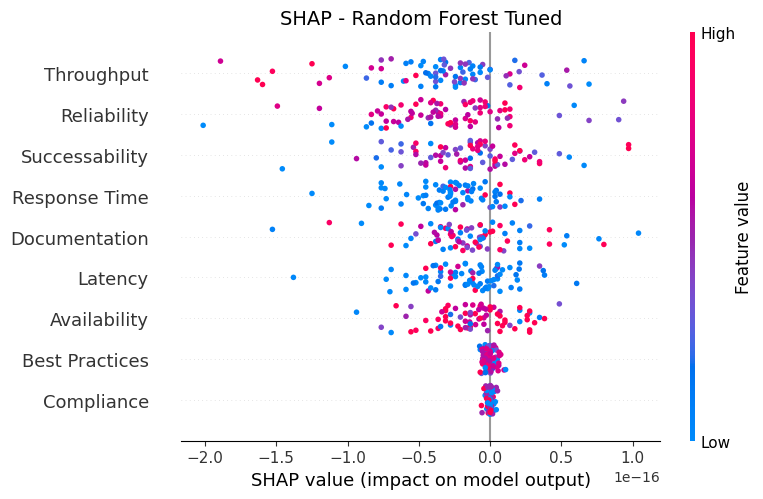


=== XGBoost Tuned ===
Type: <class 'numpy.ndarray'>
Shape before processing: (77, 9, 4)
Shape after averaging: (77, 9)


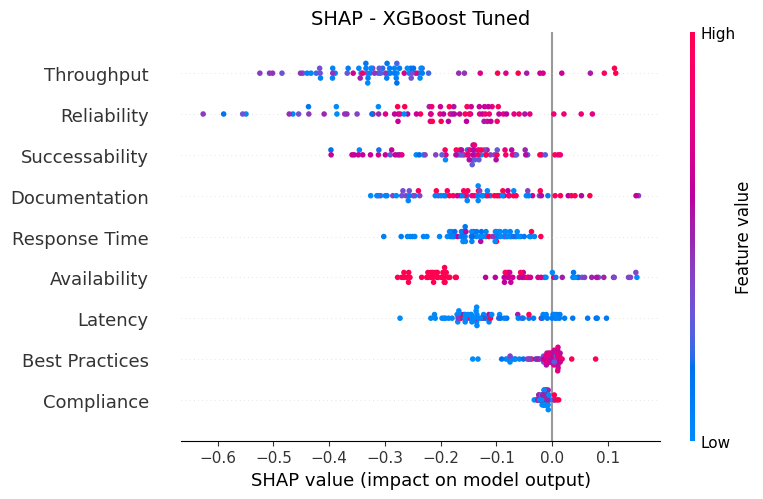


=== Logistic Regression Tuned ===
Type: <class 'numpy.ndarray'>
Shape before processing: (77, 9, 4)
Shape after averaging: (77, 9)


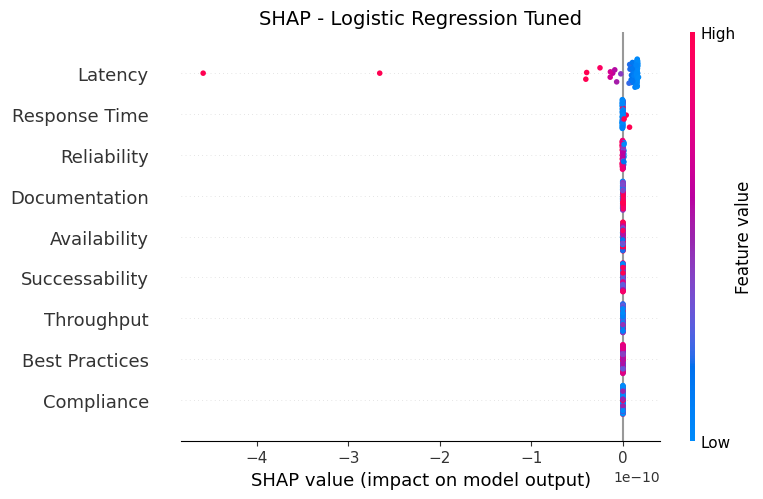

In [24]:
# Test data DataFrame with feature names
X_test_df = pd.DataFrame(X_test, columns=feature_cols)

def process_shap(model, model_name, explainer_type="tree"):
    print(f"\n=== {model_name} ===")
    
    # Explainer type
    if explainer_type == "tree":
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.LinearExplainer(model, X_test_df)
    
    shap_values = explainer.shap_values(X_test_df)

    # Shapes
    print("Type:", type(shap_values))
    print("Shape before processing:", np.array(shap_values).shape)

    # Handle multi-class
    if isinstance(shap_values, list):
        
        shap_values = np.array(shap_values).mean(axis=0) 
    elif shap_values.ndim == 3:
        
        shap_values = shap_values.mean(axis=2) 

    print("Shape after averaging:", shap_values.shape)

    # Plot
    plt.title(f"SHAP - {model_name}", fontsize=14)
    shap.summary_plot(shap_values, X_test_df, feature_names=feature_cols, plot_type="dot", max_display=len(feature_cols))

# 1. RandomForest Tuned
process_shap(tuned_models['RandomForest_Tuned'], "Random Forest Tuned", explainer_type="tree")

# 2. XGBoost Tuned
process_shap(tuned_models['XGBoost_Tuned'], "XGBoost Tuned", explainer_type="tree")

# 3. Logistic Regression Tuned
process_shap(tuned_models['LogisticRegression_Tuned'].named_steps['classifier'], "Logistic Regression Tuned", explainer_type="linear")

Top Influential Features Across Models:
- Response Time and Successability consistently show the strongest impact on predictions.
- Throughput and Availability also contribute but to a lesser extent.
- Interaction Effects: SHAP interaction plots indicate weak feature interactions overall, meaning predictions rely on combined effects rather than a single dominant feature.

Model-Specific Observations:
- Random Forest and XGBoost emphasize performance and reliability metrics.
- Logistic Regression highlights latency-related features (e.g., Response Time).

Interpretability Insight: No single feature overwhelmingly drives predictions; instead, multiple features collectively influence the outcome, reinforcing the need for a balanced feature set.

---
# **5. Export Metrics**
---

## 5.1 Save Model + Preprocessor

In [25]:
# Tuned models dictionary
tuned_models = {
    "LogisticRegression_Tuned": lr_search.best_estimator_,
    "RandomForest_Tuned": random_search.best_estimator_,
    "XGBoost_Tuned": xgb_search.best_estimator_
}

# Save each model with its preprocessor and metadata
for name, model in tuned_models.items():
    package = {
        "model": model,
        "features": feature_cols,
        "classes": label_encoder.classes_
    }
    model_path = f"models/classification/model_package_{name}.pkl"
    dump(package, model_path)
    print(f"Saved model package at: {model_path}")

Saved model package at: models/classification/model_package_LogisticRegression_Tuned.pkl
Saved model package at: models/classification/model_package_RandomForest_Tuned.pkl
Saved model package at: models/classification/model_package_XGBoost_Tuned.pkl


Afterwards to load the model:

`from joblib import load`

`package = load(model_path)`

`model = package["model"]`

`features = package["features"]`

`classes = package["classes"]`

Then to use it:
`predictions = model.predict(new_data[features])`

In [26]:
classes = np.unique(y_test)

# Loop through each tuned model and save metrics individually
for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    metrics = {
        "model_name": name,
        "accuracy": round(accuracy_score(y_test, y_pred), 4),
        "precision": round(precision_score(y_test, y_pred, average='macro'), 4),
        "recall": round(recall_score(y_test, y_pred, average='macro'), 4),
        "f1_score": round(f1_score(y_test, y_pred, average='macro'), 4),
        "roc_auc": round(roc_auc_score(label_binarize(y_test, classes=classes), y_prob, average='macro', multi_class='ovr'), 4)
    }
    
    # File paths for each model
    json_path = f"models/classification/{name}_metrics.json"
    csv_path = f"models/classification/{name}_metrics.csv"
    
    # Save JSON
    with open(json_path, "w") as f:
        json.dump(metrics, f, indent=4)
    
    # Save CSV
    pd.DataFrame([metrics]).to_csv(csv_path, index=False)
    
    print(f"Metrics saved for {name}: {json_path}, {csv_path}")

Metrics saved for LogisticRegression_Tuned: models/classification/LogisticRegression_Tuned_metrics.json, models/classification/LogisticRegression_Tuned_metrics.csv
Metrics saved for RandomForest_Tuned: models/classification/RandomForest_Tuned_metrics.json, models/classification/RandomForest_Tuned_metrics.csv
Metrics saved for XGBoost_Tuned: models/classification/XGBoost_Tuned_metrics.json, models/classification/XGBoost_Tuned_metrics.csv


## 5.2 Model Card

Markdown file summarizing the model

In [29]:

all_metrics = []  # Collect metrics for all tuned models
classes = np.unique(y_test)

for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    metrics = {
        "model_name": name,
        "accuracy": round(accuracy_score(y_test, y_pred), 4),
        "precision": round(precision_score(y_test, y_pred, average='macro'), 4),
        "recall": round(recall_score(y_test, y_pred, average='macro'), 4),
        "f1_score": round(f1_score(y_test, y_pred, average='macro'), 4),
        "roc_auc": round(roc_auc_score(label_binarize(y_test, classes=classes), y_prob, average='macro', multi_class='ovr'), 4)
    }
    all_metrics.append(metrics)


# Build combined model card
model_card = f"""
# Model Card: Classification Models Comparison
**Version:** v1.0  
**Date:** 2025-11-24  
**Owner:** Data & AI Academy  

## Data
- Source: QWS dataset (QoS metrics for web services)
- Target: Service Class (1-4)
- Preprocessing: Scaling, encoding

## Features
- {', '.join(feature_cols)}

## Models and Performance
| Model                  | Accuracy | Precision | Recall | F1 Score | ROC-AUC |
|------------------------|----------|-----------|--------|----------|---------|
"""

for m in all_metrics:  # all_metrics from Task 2 loop
    model_card += f"| {m['model_name']} | {m['accuracy']} | {m['precision']} | {m['recall']} | {m['f1_score']} | {m['roc_auc']} |\n"

model_card += """
## Limitations
- May underperform on unseen distributions
- Sensitive to feature scaling

## Intended Use
- Predictive analytics for service classification
- Not for high-stakes decisions without human review.
"""

# Save combined model card
with open("models/classification/model_card_all_models.md", "w") as f:
    f.write(model_card)

print("Combined model card created at: models/classification/model_card_all_models.md")


Combined model card created at: models/classification/model_card_all_models.md
